In [129]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, Adagrad

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

# Dataset preparation

Dataset downloaded from: https://www.kaggle.com/datasets/patriciabrezeanu/big-cats-image-classification-dataset?resource=download

## Reading color images

In [2]:
#import splitfolders 
#splitfolders.ratio('animals', output="output", seed=1337, ratio=(.8, 0.2))

In [101]:
labels = ['cheetah', 'leopard', 'lion', 'tiger']
img_size = 256

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [102]:
color_train = get_data('output/train')
color_val = get_data('output/val')

/tmp/ipykernel_46578/2693023241.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


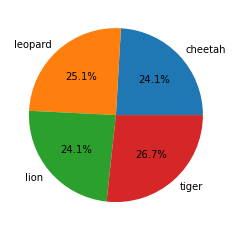

(569, 2)


In [103]:
y = np.array([np.count_nonzero(color_train[:,1] == 0), np.count_nonzero(color_train[:,1] == 1), np.count_nonzero(color_train[:,1] == 2), np.count_nonzero(color_train[:,1] == 3)])
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

print(color_train.shape)

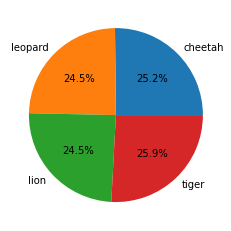

(147, 2)


In [104]:
y = np.array([np.count_nonzero(color_val[:,1] == 0), np.count_nonzero(color_val[:,1] == 1), np.count_nonzero(color_val[:,1] == 2), np.count_nonzero(color_val[:,1] == 3)])
plt.pie(y, labels = labels, autopct='%1.1f%%')
plt.show() 

print(color_val.shape)

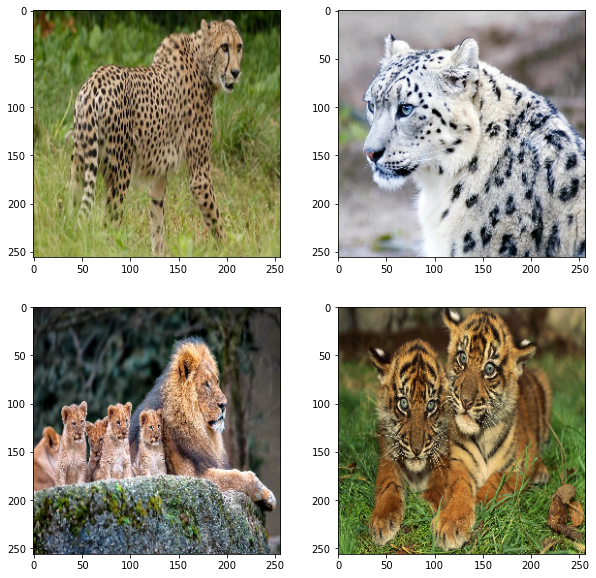

In [105]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(color_train[1][0])
axes[0, 1].imshow(color_train[160][0])
axes[1, 0].imshow(color_train[300][0])
axes[1, 1].imshow(color_train[450][0])


# Grayscale image preparation

In [106]:
def get_gray_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                data.append([gray, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [107]:
gray_train = get_gray_data('output/train')
gray_val = get_gray_data('output/val')

/tmp/ipykernel_46578/109414422.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


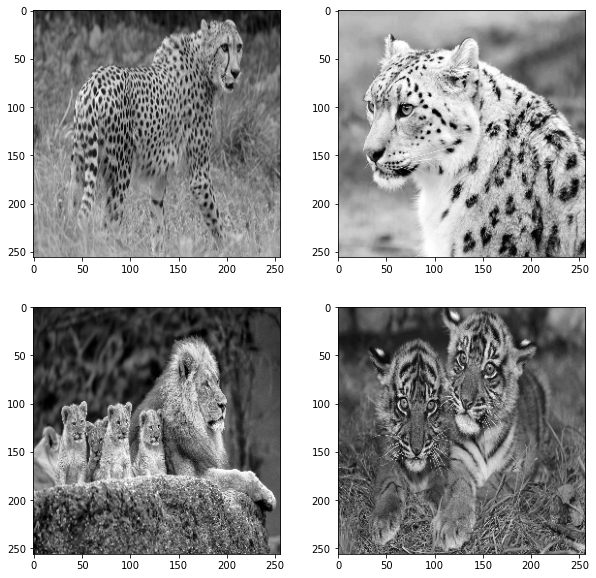

In [108]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(gray_train[1][0], cmap='gray')
axes[0, 1].imshow(gray_train[160][0], cmap='gray')
axes[1, 0].imshow(gray_train[300][0], cmap='gray')
axes[1, 1].imshow(gray_train[450][0], cmap='gray')

# Noise filtering

In [109]:
def get_gray_filtered_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [110]:
gray_filtered_train = get_gray_filtered_data('output/train')
gray_filtered_val = get_gray_filtered_data('output/val')

/tmp/ipykernel_46578/3179082502.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


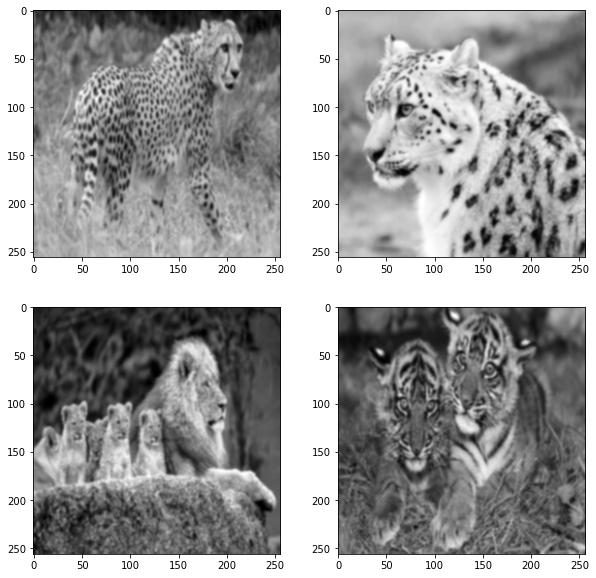

In [111]:
rows=2
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

axes[0, 0].imshow(gray_filtered_train[1][0], cmap='gray')
axes[0, 1].imshow(gray_filtered_train[160][0], cmap='gray')
axes[1, 0].imshow(gray_filtered_train[300][0], cmap='gray')
axes[1, 1].imshow(gray_filtered_train[450][0], cmap='gray')

# Dataset expansion

In [112]:
from skimage.exposure import adjust_gamma

In [141]:
def get_expanded_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                gray = cv2.cvtColor(resized_arr, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                flipped = tf.image.flip_left_right(resized_arr)
                gray = cv2.cvtColor(np.float32(flipped), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                flipped = tf.image.flip_up_down(resized_arr)
                gray = cv2.cvtColor(np.float32(flipped), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
                image_dark = adjust_gamma(resized_arr, gamma=2,gain=1)
                gray = cv2.cvtColor(np.float32(image_dark), cv2.COLOR_RGB2GRAY)
                blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1, sigmaY=1)
                data.append([blur, class_num])
                
            except Exception as e:
                print(e)
    return np.array(data)

In [142]:
expanded_train = get_expanded_data('output/train')
expanded_val = get_expanded_data('output/val')

/tmp/ipykernel_46578/50351030.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [115]:
print(expanded_train.shape)
print(expanded_val.shape)

(2276, 2)
(588, 2)


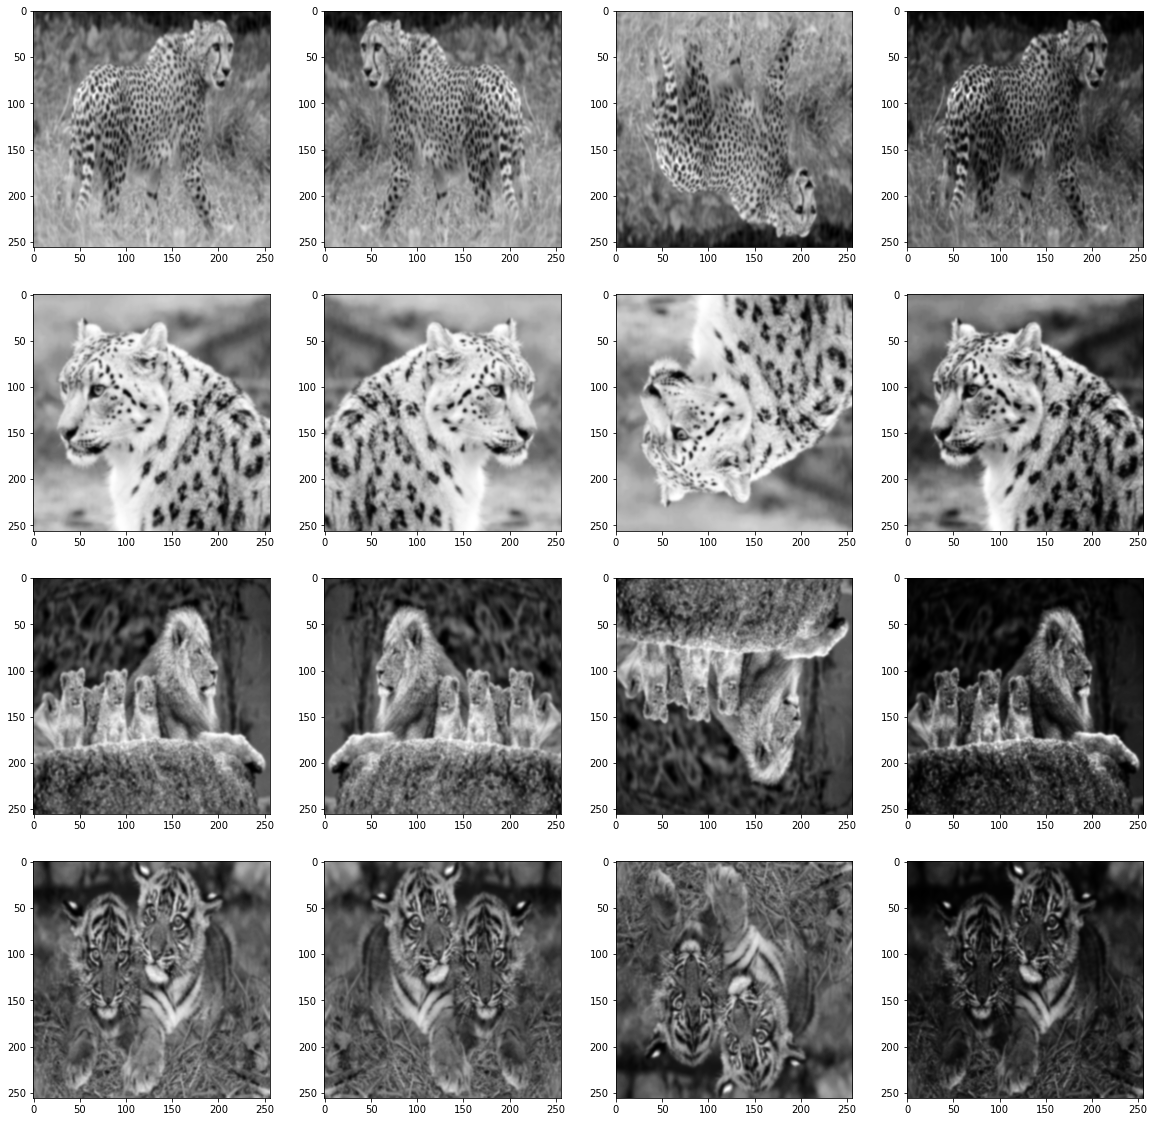

In [116]:
rows=4
cols = 4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

axes[0, 0].imshow(expanded_train[4][0], cmap='gray')
axes[0, 1].imshow(expanded_train[5][0], cmap='gray')
axes[0, 2].imshow(expanded_train[6][0], cmap='gray')
axes[0, 3].imshow(expanded_train[7][0], cmap='gray')

axes[1, 0].imshow(expanded_train[640][0], cmap='gray')
axes[1, 1].imshow(expanded_train[641][0], cmap='gray')
axes[1, 2].imshow(expanded_train[642][0], cmap='gray')
axes[1, 3].imshow(expanded_train[643][0], cmap='gray')

axes[2, 0].imshow(expanded_train[1200][0], cmap='gray')
axes[2, 1].imshow(expanded_train[1201][0], cmap='gray')
axes[2, 2].imshow(expanded_train[1202][0], cmap='gray')
axes[2, 3].imshow(expanded_train[1203][0], cmap='gray')

axes[3, 0].imshow(expanded_train[1800][0], cmap='gray')
axes[3, 1].imshow(expanded_train[1801][0], cmap='gray')
axes[3, 2].imshow(expanded_train[1802][0], cmap='gray')
axes[3, 3].imshow(expanded_train[1803][0], cmap='gray')

In [117]:
x_color_train = []
y_color_train = []
x_color_val = []
y_color_val = []

for feature, label in color_train:
  x_color_train.append(feature)
  y_color_train.append(label)

for feature, label in color_val:
  x_color_val.append(feature)
  y_color_val.append(label)

# Normalize the data
x_color_train = np.array(x_color_train) / 255
x_color_val = np.array(x_color_val) / 255

x_color_train.reshape(-1, img_size, img_size, 1)
y_color_train = np.array(y_color_train)

x_color_val.reshape(-1, img_size, img_size, 1)
y_color_val = np.array(y_color_val)



In [118]:
x_gray_train = []
y_gray_train = []
x_gray_val = []
y_gray_val = []

for feature, label in gray_train:
  x_gray_train.append(feature)
  y_gray_train.append(label)

for feature, label in gray_val:
  x_gray_val.append(feature)
  y_gray_val.append(label)

# Normalize the data
x_gray_train = np.array(x_gray_train) / 255
x_gray_val = np.array(x_gray_val) / 255

x_gray_train.reshape(-1, img_size, img_size, 1)
y_gray_train = np.array(y_gray_train)

x_gray_val.reshape(-1, img_size, img_size, 1)
y_gray_val = np.array(y_gray_val)

In [119]:
x_gray_filtered_train = []
y_gray_filtered_train = []
x_gray_filtered_val = []
y_gray_filtered_val = []

for feature, label in gray_filtered_train:
  x_gray_filtered_train.append(feature)
  y_gray_filtered_train.append(label)

for feature, label in gray_filtered_val:
  x_gray_filtered_val.append(feature)
  y_gray_filtered_val.append(label)

# Normalize the data
x_gray_filtered_train = np.array(x_gray_filtered_train) / 255
x_gray_filtered_val = np.array(x_gray_filtered_val) / 255

x_gray_filtered_train.reshape(-1, img_size, img_size, 1)
y_gray_filtered_train = np.array(y_gray_filtered_train)

x_gray_filtered_val.reshape(-1, img_size, img_size, 1)
y_gray_filtered_val = np.array(y_gray_filtered_val)

In [143]:
x_expanded_train = []
y_expanded_train = []
x_expanded_val = []
y_expanded_val = []

for feature, label in expanded_train:
  x_expanded_train.append(feature)
  y_expanded_train.append(label)

for feature, label in expanded_val:
  x_expanded_val.append(feature)
  y_expanded_val.append(label)

# Normalize the data
x_expanded_train = np.array(x_expanded_train) / 255
x_expanded_val = np.array(x_expanded_val) / 255

x_expanded_train.reshape(-1, img_size, img_size, 1)
y_expanded_train = np.array(y_expanded_train)

x_expanded_val.reshape(-1, img_size, img_size, 1)
y_expanded_val = np.array(y_expanded_val)

## Neural network

### Neural network for colour images

In [23]:
modelcolour = Sequential()
modelcolour.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
modelcolour.add(MaxPool2D())

modelcolour.add(Conv2D(32, 3, padding="same", activation="relu"))
modelcolour.add(MaxPool2D())

modelcolour.add(Conv2D(64, 3, padding="same", activation="relu"))
modelcolour.add(MaxPool2D())
modelcolour.add(Dropout(0.4))

modelcolour.add(Flatten())
modelcolour.add(Dense(128,activation="relu"))
modelcolour.add(Dense(4, activation="softmax"))

modelcolour.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

### Neural network for gray images

In [47]:
modelgray = Sequential()
modelgray.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,1)))
modelgray.add(MaxPool2D())

modelgray.add(Conv2D(32, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())

modelgray.add(Conv2D(64, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())
modelgray.add(Dropout(0.4))

modelgray.add(Flatten())
modelgray.add(Dense(128,activation="relu"))
modelgray.add(Dense(4, activation="softmax"))

modelgray.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)      

### Models training

In [49]:
opt = Adam(learning_rate=0.0001)
modelcolour.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])
modelgray.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

In [26]:
historycolour = modelcolour.fit(x_color_train, y_color_train, batch_size = 16, epochs=20, shuffle = True)

Epoch 1/20
36/36 [==============================] - 14s 373ms/step - loss: 1.3718 - accuracy: 0.2847
Epoch 2/20
36/36 [==============================] - 14s 379ms/step - loss: 1.2027 - accuracy: 0.4622
Epoch 3/20
36/36 [==============================] - 13s 375ms/step - loss: 1.0644 - accuracy: 0.5466
Epoch 4/20
36/36 [==============================] - 14s 375ms/step - loss: 0.8935 - accuracy: 0.6696
Epoch 5/20
36/36 [==============================] - 13s 372ms/step - loss: 0.7775 - accuracy: 0.6977
Epoch 6/20
36/36 [==============================] - 13s 375ms/step - loss: 0.6874 - accuracy: 0.7610
Epoch 7/20
36/36 [==============================] - 14s 379ms/step - loss: 0.5612 - accuracy: 0.8084
Epoch 8/20
36/36 [==============================] - 13s 374ms/step - loss: 0.4494 - accuracy: 0.8805
Epoch 9/20
36/36 [==============================] - 13s 374ms/step - loss: 0.3747 - accuracy: 0.8910
Epoch 10/20
36/36 [==============================] - 13s 375ms/step - loss: 0.3387 - accura

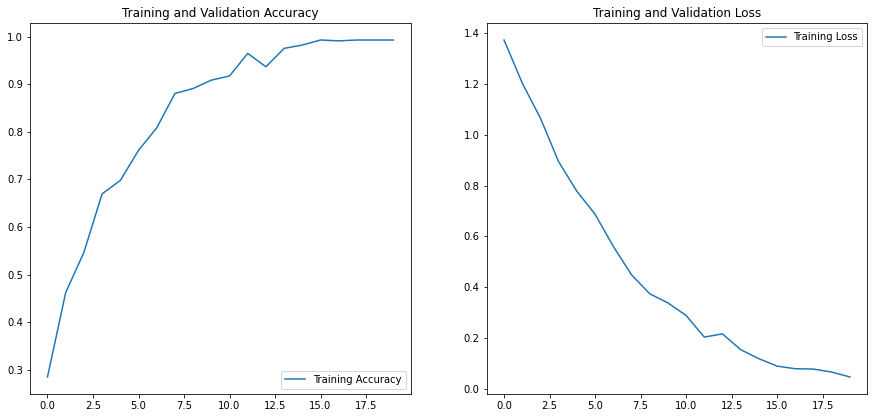

In [31]:
acc = historycolour.history['accuracy']
#val_acc = historycolour.history['val_accuracy']
loss = historycolour.history['loss']
#val_loss = historycolour.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
def test_accuracy(y_true, y_pred):
    pred = np.sum(y_true == y_pred)
    n = np.size(y_true)
    return pred/n * 100

5/5 [==============================] - 1s 93ms/step
Test accuracy:59.863945578231295%


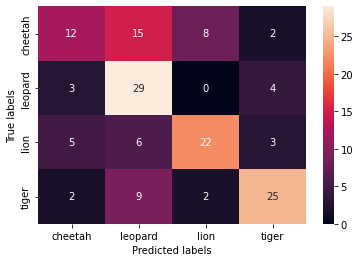

In [30]:
y_pred = modelcolour.predict(x_color_val)

confusion = confusion_matrix(y_color_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_color_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

In [32]:
historygray = modelgray.fit(x_gray_train, y_gray_train, batch_size = 16, epochs=20, shuffle = True)

Epoch 1/20
32/32 [==============================] - 12s 373ms/step - loss: 1.3929 - accuracy: 0.3281 - val_loss: 1.5404 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 12s 367ms/step - loss: 1.2207 - accuracy: 0.4258 - val_loss: 1.5159 - val_accuracy: 0.0877
Epoch 3/20
32/32 [==============================] - 12s 372ms/step - loss: 1.0058 - accuracy: 0.5801 - val_loss: 0.9892 - val_accuracy: 0.5439
Epoch 4/20
32/32 [==============================] - 12s 371ms/step - loss: 0.8362 - accuracy: 0.6934 - val_loss: 1.0899 - val_accuracy: 0.4912
Epoch 5/20
32/32 [==============================] - 12s 375ms/step - loss: 0.6752 - accuracy: 0.7520 - val_loss: 1.2695 - val_accuracy: 0.3860
Epoch 6/20
32/32 [==============================] - 12s 376ms/step - loss: 0.6090 - accuracy: 0.7734 - val_loss: 1.0898 - val_accuracy: 0.5088
Epoch 7/20
32/32 [==============================] - 12s 373ms/step - loss: 0.4760 - accuracy: 0.8555 - val_loss: 1.0507 - val_accuracy: 0.

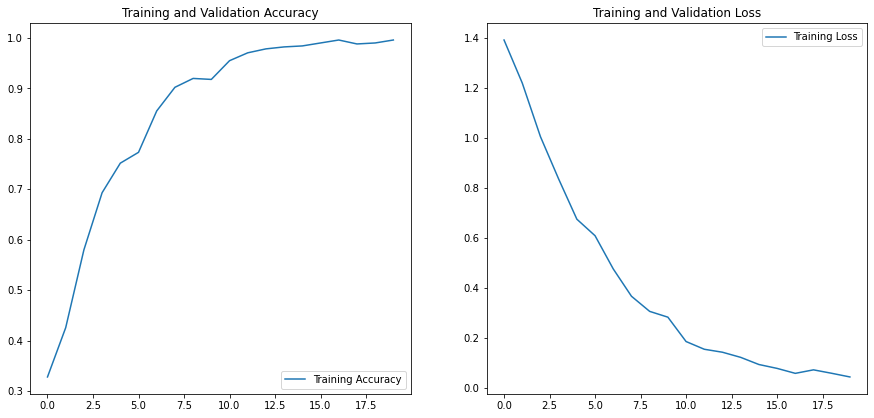

In [33]:
acc = historygray.history['accuracy']
#val_acc = historygray.history['val_accuracy']
loss = historygray.history['loss']
#val_loss = historygray.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

5/5 [==============================] - 1s 96ms/step
Test accuracy:62.585034013605444%


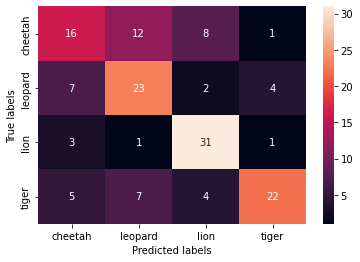

In [34]:
y_pred = modelgray.predict(x_gray_val)

confusion = confusion_matrix(y_gray_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_gray_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

In [44]:
historygrayfilterred = modelgray.fit(x_gray_filtered_train, y_gray_filtered_train, batch_size = 16, epochs=20, shuffle = True)

Epoch 1/20
36/36 [==============================] - 13s 364ms/step - loss: 1.3814 - accuracy: 0.2689
Epoch 2/20
36/36 [==============================] - 13s 367ms/step - loss: 1.2808 - accuracy: 0.4464
Epoch 3/20
36/36 [==============================] - 13s 364ms/step - loss: 1.1741 - accuracy: 0.5378
Epoch 4/20
36/36 [==============================] - 13s 362ms/step - loss: 1.0361 - accuracy: 0.5817
Epoch 5/20
36/36 [==============================] - 13s 361ms/step - loss: 0.9109 - accuracy: 0.6661
Epoch 6/20
36/36 [==============================] - 13s 356ms/step - loss: 0.8226 - accuracy: 0.6854
Epoch 7/20
36/36 [==============================] - 13s 362ms/step - loss: 0.7322 - accuracy: 0.7364
Epoch 8/20
36/36 [==============================] - 13s 364ms/step - loss: 0.6292 - accuracy: 0.7996
Epoch 9/20
36/36 [==============================] - 13s 362ms/step - loss: 0.5381 - accuracy: 0.8366
Epoch 10/20
36/36 [==============================] - 13s 363ms/step - loss: 0.5178 - accura

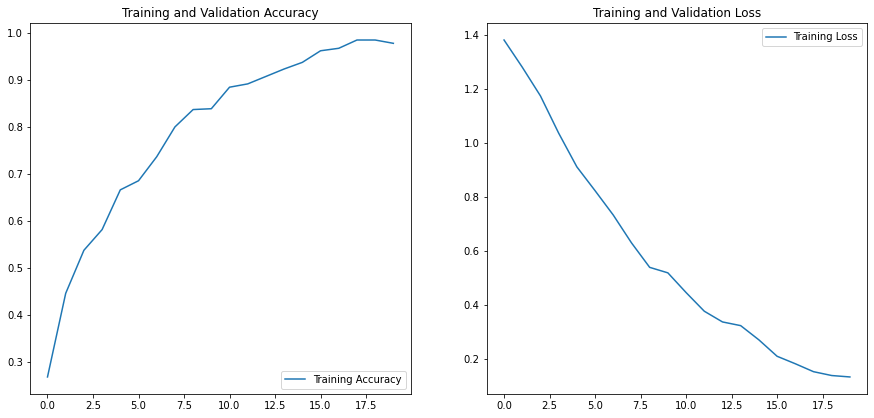

In [45]:
acc = historygrayfilterred.history['accuracy']
#val_acc = historygrayfilterred.history['val_accuracy']
loss = historygrayfilterred.history['loss']
#val_loss = historygrayfilterred.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

5/5 [==============================] - 1s 96ms/step
Test accuracy:56.4625850340136%


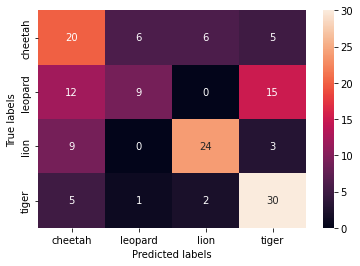

In [46]:
y_pred = modelgray.predict(x_gray_filtered_val)

confusion = confusion_matrix(y_gray_filtered_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_gray_filtered_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

In [50]:
historyexpanded = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=20, shuffle = True)

Epoch 1/20
143/143 [==============================] - 52s 361ms/step - loss: 1.3533 - accuracy: 0.3133
Epoch 2/20
143/143 [==============================] - 52s 367ms/step - loss: 1.1651 - accuracy: 0.4974
Epoch 3/20
143/143 [==============================] - 53s 367ms/step - loss: 1.0005 - accuracy: 0.6063
Epoch 4/20
143/143 [==============================] - 52s 365ms/step - loss: 0.8992 - accuracy: 0.6380
Epoch 5/20
143/143 [==============================] - 53s 367ms/step - loss: 0.7925 - accuracy: 0.6757
Epoch 6/20
143/143 [==============================] - 52s 363ms/step - loss: 0.7080 - accuracy: 0.7307
Epoch 7/20
143/143 [==============================] - 52s 367ms/step - loss: 0.6284 - accuracy: 0.7627
Epoch 8/20
143/143 [==============================] - 52s 363ms/step - loss: 0.5753 - accuracy: 0.7996
Epoch 9/20
143/143 [==============================] - 53s 369ms/step - loss: 0.5080 - accuracy: 0.8352
Epoch 10/20
143/143 [==============================] - 52s 367ms/step - l

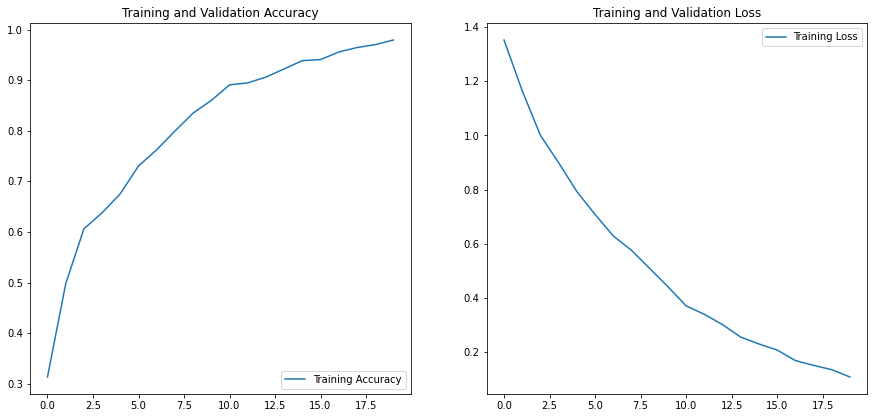

In [51]:
acc = historyexpanded.history['accuracy']
#val_acc = historyexpanded.history['val_accuracy']
loss = historyexpanded.history['loss']
#val_loss = historyexpanded.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 2s 95ms/step
Test accuracy:63.435374149659864%


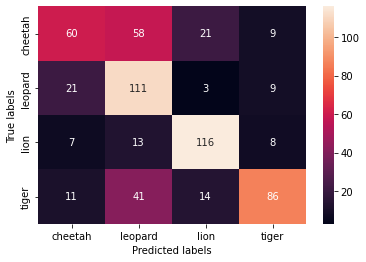

In [52]:
y_pred = modelgray.predict(x_expanded_val)

confusion = confusion_matrix(y_expanded_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_expanded_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')

## Testing neural network parameters

Additional con2D, maxpool and dropout layers. accuracy: 63.60

Additional dropout, with 0.2 rate. accuracy: 66.66

Selu activation function. accuracy: 61.39

learning rate 0.001. accuracy: 62.39

RMSprop accuracy: 67.69

Adagras accuracy: 38.44

In [138]:
modelgray = Sequential()
modelgray.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,1)))
modelgray.add(MaxPool2D())

modelgray.add(Conv2D(32, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())
modelgray.add(Dropout(0.2))

modelgray.add(Conv2D(64, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())
modelgray.add(Dropout(0.2))

modelgray.add(Conv2D(64, 3, padding="same", activation="relu"))
modelgray.add(MaxPool2D())
modelgray.add(Dropout(0.2))

modelgray.add(Flatten())
modelgray.add(Dense(128,activation="relu"))
modelgray.add(Dense(4, activation="softmax"))

modelgray.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 64, 64, 64)      

In [139]:
opt = RMSprop(learning_rate=0.0001)
modelgray.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

In [140]:
historyexpanded = modelgray.fit(x_expanded_train, y_expanded_train, batch_size = 16, epochs=50, shuffle = True, validation_data=(x_expanded_val, y_expanded_val))

Epoch 1/50
143/143 [==============================] - 55s 383ms/step - loss: 1.3733 - accuracy: 0.2865 - val_loss: 1.3302 - val_accuracy: 0.3452
Epoch 2/50
143/143 [==============================] - 55s 384ms/step - loss: 1.2427 - accuracy: 0.4310 - val_loss: 1.1983 - val_accuracy: 0.4813
Epoch 3/50
143/143 [==============================] - 55s 385ms/step - loss: 1.1074 - accuracy: 0.5224 - val_loss: 1.1263 - val_accuracy: 0.4983
Epoch 4/50
143/143 [==============================] - 54s 377ms/step - loss: 1.0376 - accuracy: 0.5734 - val_loss: 1.0921 - val_accuracy: 0.5017
Epoch 5/50
143/143 [==============================] - 54s 379ms/step - loss: 0.9860 - accuracy: 0.5905 - val_loss: 1.0800 - val_accuracy: 0.5068
Epoch 6/50
143/143 [==============================] - 54s 379ms/step - loss: 0.9398 - accuracy: 0.6046 - val_loss: 1.0670 - val_accuracy: 0.5136
Epoch 7/50
143/143 [==============================] - 54s 379ms/step - loss: 0.9094 - accuracy: 0.6239 - val_loss: 0.9994 - val_ac

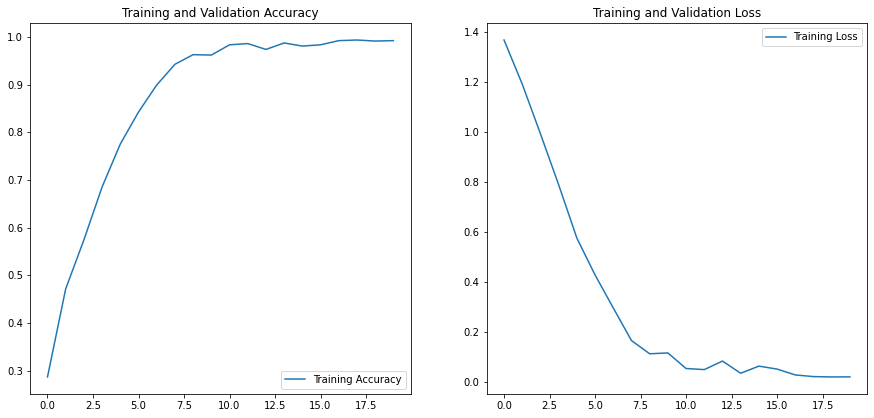

In [87]:
acc = historyexpanded.history['accuracy']
#val_acc = historyexpanded.history['val_accuracy']
loss = historyexpanded.history['loss']
#val_loss = historyexpanded.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 2s 98ms/step
Test accuracy:60.71428571428571%


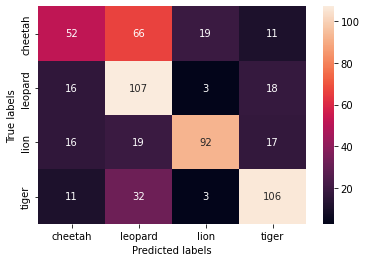

In [88]:
y_pred = modelgray.predict(x_expanded_val)

confusion = confusion_matrix(y_expanded_val, y_pred.argmax(axis=-1))
ax = plt.subplot()
axis_labels = ['cheetah','leopard','lion', 'tiger'] 
sns.heatmap(confusion, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

accuracy = test_accuracy(y_expanded_val, y_pred.argmax(axis=-1))
print('Test accuracy:' + str(accuracy) + '%')